To run the code, please setup the anaconda environment by running the following code.
```bash
conda env create -f env-gpu.yaml
conda activate ML
```

In [1]:
import numpy as np
import json_lines

from keras_xlnet.backend import keras
from keras_xlnet import PretrainedList, get_pretrained_paths
from keras_xlnet import Tokenizer
from keras_bert.layers import Extract
from keras_xlnet import load_trained_model_from_checkpoint, ATTENTION_TYPE_BI

from sklearn.model_selection import train_test_split

Hyper-parameters

In [2]:
EPOCH = 5
BATCH_SIZE = 20
SEQ_LEN = 128 # max length of sequence
LR = 4e-6

Use the pretrained model

Download from [google](https://storage.googleapis.com/xlnet/released_models/cased_L-12_H-768_A-12.zip)

Here it will download it automatically

In [3]:
paths = get_pretrained_paths(PretrainedList.en_cased_base)

Model definition

In [4]:
def get_model():
    model = load_trained_model_from_checkpoint(
        config_path=paths.config,
        checkpoint_path=paths.model,
        batch_size=BATCH_SIZE,
        memory_len=256,
        target_len=SEQ_LEN,
        in_train_phase=False,
        attention_type=ATTENTION_TYPE_BI,
    )

    last = Extract(index=-1, name='Extract')(model.output)
    dense = keras.layers.Dense(units=768, activation='tanh', name='Dense')(last)
    dropout = keras.layers.Dropout(rate=0.1, name='Dropout')(dense)
    output = keras.layers.Dense(units=2, activation='softmax', name='Softmax')(dropout)
    model = keras.models.Model(inputs=model.inputs, outputs=output)
    # model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(lr=LR),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )
    return model

Data loader

In [5]:
def load_data(tokenizer: Tokenizer, path, SEQ_LEN, text_label='trans_en', target_label='voted_up'):
    tokens, classes = [], []
    with open(path, 'rb') as reader:
        for line in json_lines.reader(reader):
            encoded = tokenizer.encode(line[text_label])[:SEQ_LEN - 1]
            encoded = [tokenizer.SYM_PAD] * (SEQ_LEN - 1 - len(encoded)) + encoded + [tokenizer.SYM_CLS]
            tokens.append(encoded)
            classes.append(int(line[target_label]))
    tokens, classes = np.array(tokens), np.array(classes)
    return tokens, classes

def get_X_array(X):
    segments = np.zeros_like(X)
    segments[:, -1] = 1
    lengths = np.zeros_like(X[:, :1])
    return [X, segments, lengths]

In [6]:
def model_train(model, target_label='voted_up', model_name='xlnet_voted_up'):
    X, y = load_data(tokenizer, 'data/reviews_112_trans-en.jl',
        SEQ_LEN=SEQ_LEN, target_label=target_label)
    X_train, X_test, y_train, y_test = train_test_split(X,
        y, test_size=0.1, random_state=42)

    mcp_save = keras.callbacks.ModelCheckpoint("result/"+model_name+'.best.h5',
        save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')

    model.fit(
        get_X_array(X_train),
        y_train,
        epochs=EPOCH,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2), mcp_save]
    )

    model.save_weights("result/"+model_name+".h5")

In [7]:
tokenizer = Tokenizer(paths.vocab)

# XLNet Early access

Training process

In [8]:
model = get_model()
model_train(model, 'early_access', 'xlnet_early_access')

Instructions for updating:
`inputs` is now automatically inferred
Epoch 1/5
203/203 [==============================] - 181s 890ms/step - loss: 0.4136 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.2987 - val_sparse_categorical_accuracy: 0.9133
Epoch 2/5
203/203 [==============================] - 178s 879ms/step - loss: 0.3288 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.3054 - val_sparse_categorical_accuracy: 0.9156
Epoch 3/5
203/203 [==============================] - 160s 789ms/step - loss: 0.2415 - sparse_categorical_accuracy: 0.9059 - val_loss: 0.3286 - val_sparse_categorical_accuracy: 0.9089


Evaluation

In [9]:
import json
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [10]:
def plot_roc(pred, y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    try:
        auc = roc_auc_score(y, pred)
    except ValueError:
        auc = "undefined"

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(fpr, tpr, color='red')
    ax.plot([0,1], [0,1], color='black', linestyle='--')
    ax.set_title(f"AUC: {auc}")

In [11]:
model.load_weights("result/xlnet_early_access.best.h5")

In [12]:
X, y = load_data(tokenizer, 'data/reviews_112_trans-en.jl',
        SEQ_LEN=SEQ_LEN, target_label='early_access')
preds = model.predict(get_X_array(X), verbose=True, batch_size=BATCH_SIZE)
result_max = preds.argmax(axis=-1)
tn, fp, fn, tp = confusion_matrix(y, result_max).ravel()

print('Confusion matrix:')
print('[{}, {}]'.format(tp, fp))
print('[{}, {}]'.format(fn, tn))

250/250 [==============================] - 56s 225ms/step
Confusion matrix:
[41, 2]
[510, 4447]


In [13]:
print('Accuracy: %.4f' % accuracy_score(y, result_max))

Accuracy: 0.8976


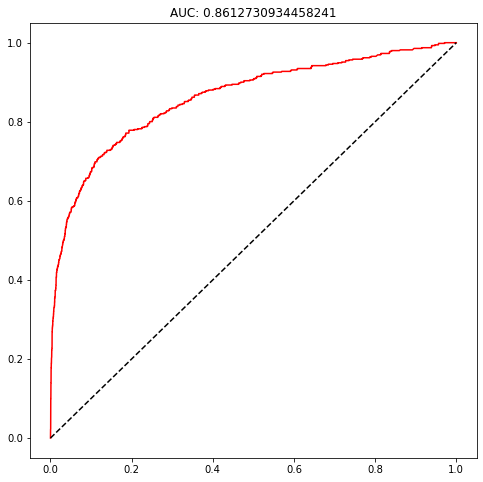

In [14]:
plot_roc(preds[:,1], y)